# TSTR Methodology
**TSTR (Train on Synthetic, Test on Real)**: The primary goal here is to train the classification model using only synthetic heartbeat data generated by a GAN, and then test it on real ECG segments from the MIT-BIH Arrhythmia dataset. This approach can indicate whether the synthetic data distribution is representative enough of the real-world ECG distribution, or whether there's a gap the model cannot overcome.
1. Train on Synthetic: Use only GAN-generated ECG heartbeat segments to fit the model.
2. Test on Real: Evaluate the trained model on real ECG segments to see how well it performs on authentic data.

If the Performance on real data is high, it suggests that the synthetic data effectively captures the real data distribution. If performance is poor, it may indicate that the synthetic data is not realistic enough, or lacks important feature of real ECG signals.

# 1. Setup and Imports
* Importing the necessary libraries.
* Mount Google Drive to load and save files.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import glob
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from google.colab import drive

In [4]:
# Mount drive to access database
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Imports local libraries
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Masters_Code/Utils')

from ECGUtils import ECGUtils

# 2. Load Synthetic Data (Training Data) and Processing
* Specify the file paths for the GAN-generated synthetic heartbeat segments.
* These will serve as our **training** data.
* We load the data, label-encode the classes, and prepare them for the model.

In [6]:
# Define the path to synthetic data files
synthetic_data_files = {
    'N': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_tstr_N.npy',
    'L': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_tstr_L.npy',
    'R': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_tstr_R.npy',
    'V': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_tstr_V.npy',
    'A': '/content/drive/My Drive/Colab Notebooks/Generated Data/generated_heartbeats_tstr_A.npy'
}

# Load the synthetic data from the files
synthetic_segments, synthetic_labels = ECGUtils.load_synthetic_data(synthetic_data_files)

# Encode labels to integers
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(synthetic_labels)
print("Encoded labels:", np.unique(integer_encoded))

# Convert labels to one-hot encoding
synthetic_one_hot_labels = to_categorical(integer_encoded)
print("One-hot labels shape:", synthetic_one_hot_labels.shape)

Synthetic data loaded.
Synthetic data shape: (25000, 256)
Synthetic labels shape: (25000,)
Encoded labels: [0 1 2 3 4]
One-hot labels shape: (25000, 5)


**Data Normalization (Synthetic)**
* We fit a **StandardScaler** on the synthetic data and use it to normalize the synthetic segments.

In [7]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the synthetic data and transform
synthetic_segments_normalized = scaler.fit_transform(synthetic_segments)

# Reshape data for the model
synthetic_segments_normalized = synthetic_segments_normalized.reshape(-1, 256, 1)
print("Synthetic data normalized shape:", synthetic_segments_normalized.shape)

Synthetic data normalized shape: (25000, 256, 1)


# 3. Load Real Data (Testing Data)
* We define the heartbeat classes and load real ECG segments from the MIT-BIH dataset.
* The real data is used only at the testing stage.

In [8]:
# Define the heartbeat classes
heartbeat_classes = ['N', 'L', 'R', 'V', 'A']

# List of records in the MIT-BIH dataset
record_files = glob.glob('/content/drive/My Drive/Colab Notebooks/Datasets/mitbih_data/*.dat')
record_names = [os.path.basename(f).split('.')[0] for f in record_files]

# Exclude records with paced beats
excluded_records = ['102', '104', '107', '217']
record_names = [rec for rec in record_names if rec not in excluded_records]

# Extract heartbeat segments for the specified classes
segments, labels = ECGUtils.extract_heartbeat_segments(record_names, heartbeat_type=heartbeat_classes, max_segments=-1)

print("Data collection completed.")
print("Total number of samples collected:", len(segments))

# Convert lists to numpy arrays
real_segments = np.array(segments)
real_labels = np.array(labels)

print("Real data shape:", real_segments.shape)
print("Real labels shape:", real_labels.shape)

# Encode and on-hot enconde the real labels
real_integer_encoded = label_encoder.transform(real_labels)
real_one_hot_labels = to_categorical(real_integer_encoded)
print("Real one-hot labels shape:", real_one_hot_labels.shape)

100%|██████████| 44/44 [01:03<00:00,  1.43s/it]

Data collection completed.
Total number of samples collected: 95801
Real data shape: (95801, 256)
Real labels shape: (95801,)
Real one-hot labels shape: (95801, 5)


**Normalizing Real Data with the same scaler**
* To keep consistent scaling between synthetic and real data, **we reuse the same `StandardScaler` fitter on the synthetic data**.
* The real data is reshaped for the model.

In [9]:
# Normalize real data using the scaler fitted on synthetic data
real_segments_normalized = scaler.transform(real_segments)

# Reshape data for the model (samples, timesteps, channels)
real_segments_normalized = real_segments_normalized.reshape(-1, 256, 1)
print("Real data normalized shape:", real_segments_normalized.shape)

Real data normalized shape: (95801, 256, 1)


**Split Real Data (Even though it's only for testing)**
* In order to make the test dataset smaller, and not being the entire original database for each heartbeat type.

In [10]:
# First split into training+validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    real_segments_normalized, real_one_hot_labels, test_size=0.1, random_state=42, stratify=real_one_hot_labels)

print("Test set shape:", X_test.shape)

Test set shape: (9581, 256, 1)


# 4. Building and Compiling the Model
* The classification model is built using the utility function from `ECGUtils`.
* The same model architecture is used in other testing approaches.

In [11]:
model = ECGUtils.build_test_model()
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,285 (5.02 KB)

 Trainable params: 1,285 (5.02 KB)

 Non-trainable params: 0 (0.00 B)

**Preparing Synthetic Data and Training on Synthetic**
* Here, the Train on Synthetic is done. The synthetic data is splitted into training/validation sets and then **fits the model solely on synthetic ECG segments**.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/model_synthetic.keras', save_best_only=True, monitor='val_loss')

# Split synthetic data into training and validation
X_train_syn, X_val_syn, y_train_syn, y_val_syn = train_test_split(
    synthetic_segments_normalized, synthetic_one_hot_labels, test_size=0.1, random_state=42, stratify=synthetic_one_hot_labels)

print("Synthetic training data shape:", X_train_syn.shape)
print("Synthetic validation data shape:", X_val_syn.shape)

# Train the model
history = model.fit(
    X_train_syn, y_train_syn,
    epochs=30,
    batch_size=64,
    validation_data=(X_val_syn, y_val_syn),
    callbacks=[early_stopping, model_checkpoint]
)

Synthetic training data shape: (22500, 256, 1)
Synthetic validation data shape: (2500, 256, 1)
Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6575 - loss: 1.0320 - val_accuracy: 0.8836 - val_loss: 0.4835
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8970 - loss: 0.4343 - val_accuracy: 0.9076 - val_loss: 0.3824
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9127 - loss: 0.3544 - val_accuracy: 0.9176 - val_loss: 0.3295
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9222 - loss: 0.3145 - val_accuracy: 0.9220 - val_loss: 0.3060
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9276 - loss: 0.2751 - val_accuracy: 0.9272 - val_loss: 0.2773
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9286 - loss: 0.2693 - val_accuracy: 0.9364 - val_loss: 0.2635
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9311 - loss: 0.2580 - val_accuracy: 0.9372 - val_loss: 0.2561
Epoch 8/3

# 5. Evaluate the Results on Real Test Data
* After training the model on synthetic data, we load the best weights and then test on the real dataset (`X_test, y_test`).
* A hight accuracy here means the synthetic data managed to teach the model features that generalize well to real ECG signals. A low accuracy implies the synthetic data distribution might be substantially different from the real one.

In [13]:
# Load the best model weights
model.load_weights('/content/drive/My Drive/Colab Notebooks/model_synthetic.keras')

# Evaluate on real test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy on real data:", test_accuracy)

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3888 - loss: 3.5758
Test Accuracy on real data: 0.38649410009384155


**Classification Report and Confusion Matrix**
* Predictions are generated on the real test set to produce a classification report and a confusion matrix, showing how the model behaves on each real heartbeat class.

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           A       0.05      0.88      0.09       223
           L       0.75      0.68      0.71       795
           N       0.92      0.27      0.41      7187
           R       0.52      0.76      0.62       726
           V       0.34      0.78      0.47       650

    accuracy                           0.39      9581
   macro avg       0.51      0.67      0.46      9581
weighted avg       0.81      0.39      0.45      9581



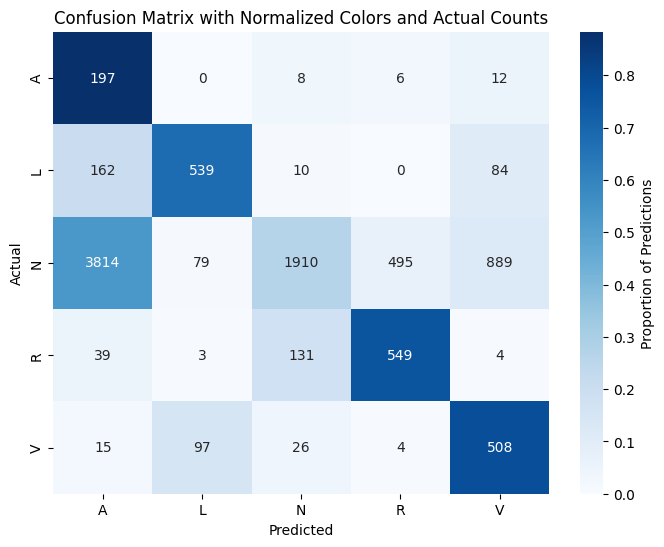

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions on the real test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix for color intensity
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)

# Plot confusion matrix with normalized colors and actual counts
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=conf_matrix, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Proportion of Predictions'})

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix with Normalized Colors and Actual Counts')
plt.show()